In [1]:
import pandas as pd
import numpy as np
import os
os.chdir('../../../../')
print(os.getcwd())
from v2.strategy.indicators.optimal_v2 import Optimal_v2
from v2.model import Trading
from v2.strategy.indicators.param import Param
from v2.strategy.indicators.roc import RateOfChange
from v2.research.scripts.notebook_utils import notebookUtils
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance


/Users/rosscopeland/Desktop/personal/code/vivaldi/back_testing


In [21]:
nu = notebookUtils()
model_name = "CLASSIFICATION_CHANGE_THIS"

In [3]:
dataset, features, indicators, scalers = nu.loadData(indicators=[('rsi', 'close'), ('optimal_v2', 'close')],
                            param_spec={},
                            optimal_threshold={'buy':0.8},
                            spans=[{'indicator_name':'willr',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [3,5,10,30]},
                                    {'indicator_name':'cci',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [3,5,10,30]},
                                    {'indicator_name':'rsi',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [3,5,10,30]},
                                    {'indicator_name':'momentum',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [3,5,10,30]},
                                    {'indicator_name':'roc',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [3,5,10,30]},
                                    {'indicator_name':'momentum',
                                    'column_name': 'RSI',
                                    'param_name': 'period',
                                    'param_values': [3,5,10,30]},
                                    {'indicator_name':'roc',
                                    'column_name': 'RSI',
                                    'param_name': 'period',
                                    'param_values': [3,5,10,30]}
                                    ],

                            scale='minmax')
        
    # create one minute, five minute, ten minute, and twenty minute slopes for macd, rsi




Loading data from BTCUSDT-1m...


In [13]:
edit_dataset = dataset.drop(["time", "open", "high", "low"], axis=1)
edit_dataset.dropna(inplace=True)
edit_dataset

,close,volume,RSI,optimal,WILLR_close_period_3,WILLR_close_period_5,WILLR_close_period_10,WILLR_close_period_30,CCI_close_period_3,CCI_close_period_5,...,RateOfChange_close_period_10,RateOfChange_close_period_30,Momentum_RSI_period_3,Momentum_RSI_period_5,Momentum_RSI_period_10,Momentum_RSI_period_30,RateOfChange_RSI_period_3,RateOfChange_RSI_period_5,RateOfChange_RSI_period_10,RateOfChange_RSI_period_30
90,4319.996912,0.048053,0.594297,0.0,0.476929,0.488858,0.498613,0.643434,0.933333,0.724138,...,0.430643,0.401906,0.478606,0.503770,0.494352,0.555047,0.204404,0.181143,0.174906,0.162865
91,4319.998456,0.030719,0.594297,0.0,0.476929,0.488858,0.498774,0.643497,0.933333,0.724138,...,0.430630,0.401904,0.478606,0.503770,0.494352,0.555047,0.204404,0.181143,0.174906,0.162865
92,4319.999228,0.179059,0.594297,0.0,0.476929,0.488858,0.498855,0.643529,0.933333,0.724138,...,0.430624,0.402986,0.478606,0.503770,0.494352,0.570287,0.204404,0.181143,0.174906,0.167805
93,4319.999614,0.501599,0.594297,0.0,0.476929,0.488858,0.498936,0.643545,0.933333,0.724138,...,0.430881,0.397691,0.478606,0.503770,0.497380,0.513006,0.204404,0.181143,0.175860,0.150353
94,4319.999807,0.019386,0.594297,0.0,0.476929,0.488858,0.498936,0.643552,0.933333,0.724138,...,0.430749,0.395053,0.478606,0.503770,0.495070,0.513006,0.204404,0.181143,0.175132,0.150353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1722408,18519.207620,5.437391,0.492830,0.0,0.476624,0.487401,0.429327,0.055142,0.909239,0.392106,...,0.425569,0.387816,0.477448,0.506112,0.465718,0.456943,0.203943,0.181977,0.164825,0.131905
1722409,18523.983810,65.068932,0.501578,0.0,0.476442,0.486870,0.436562,0.109340,1.000000,1.000000,...,0.426304,0.388045,0.494979,0.506802,0.473094,0.472400,0.210987,0.182209,0.167435,0.136492
1722410,18525.301905,15.367476,0.499362,0.0,0.476460,0.486943,0.438859,0.122343,0.680400,0.629556,...,0.428349,0.388864,0.492955,0.510220,0.494905,0.485892,0.210179,0.183429,0.175072,0.140253
1722411,18526.950952,54.298657,0.501485,0.0,0.476483,0.487035,0.441733,0.138611,0.479043,0.561493,...,0.429491,0.388718,0.489399,0.518775,0.496661,0.478026,0.208712,0.186509,0.175710,0.138068


In [14]:
trainX, testX, trainy, testy = nu.splitData(edit_dataset, split_size=0.2, y_column_name="optimal", shuffle_data=False, balance_unbalanced_data=True, balance_info={'multiplier_val':4, 'superset_class_val':0, 'randomize_concat':True})
trainX

,close,volume,RSI,WILLR_close_period_3,WILLR_close_period_5,WILLR_close_period_10,WILLR_close_period_30,CCI_close_period_3,CCI_close_period_5,CCI_close_period_10,...,RateOfChange_close_period_10,RateOfChange_close_period_30,Momentum_RSI_period_3,Momentum_RSI_period_5,Momentum_RSI_period_10,Momentum_RSI_period_30,RateOfChange_RSI_period_3,RateOfChange_RSI_period_5,RateOfChange_RSI_period_10,RateOfChange_RSI_period_30
0,4002.711190,20.878851,0.593215,0.476725,0.488032,0.492168,0.917151,1.000000,0.848931,0.621622,...,0.432458,0.397086,0.478357,0.517951,0.540299,0.522453,0.204319,0.185532,0.190314,0.153017
1,8705.628034,12.000367,0.516169,0.476767,0.488195,0.478124,0.461498,1.000000,0.946284,0.663334,...,0.433487,0.393470,0.532624,0.541600,0.532007,0.537689,0.226708,0.194790,0.188991,0.156832
2,8649.772185,19.275670,0.463023,0.476712,0.487968,0.445645,0.347674,1.000000,0.645541,0.440561,...,0.422116,0.392826,0.492839,0.518826,0.451467,0.536174,0.210505,0.186901,0.159416,0.155716
3,9705.119267,25.692917,0.519094,0.476642,0.487842,0.472405,0.846895,0.852790,0.764239,0.755259,...,0.446893,0.399603,0.509998,0.548622,0.550077,0.602285,0.216910,0.197411,0.196291,0.181059
4,9607.822250,77.650849,0.515500,0.476801,0.488337,0.482599,0.742879,0.850041,0.761405,0.638712,...,0.430268,0.396471,0.501614,0.515621,0.493533,0.555699,0.213522,0.185265,0.174588,0.163071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228650,7304.292156,14.543876,0.407115,0.476446,0.486813,0.447486,0.237804,0.385543,0.130156,0.333650,...,0.424400,0.391930,0.463930,0.510258,0.472820,0.567901,0.197721,0.183861,0.165965,0.168493
228651,10860.539442,1.430049,0.480927,0.476538,0.487051,0.430783,0.537040,0.444405,0.222761,0.297867,...,0.431518,0.401305,0.452753,0.495268,0.499762,0.608173,0.194236,0.178102,0.176906,0.185029
228652,10424.297263,132.834650,0.561952,0.476523,0.488115,0.484964,0.850455,0.624743,0.630697,0.623357,...,0.434452,0.399267,0.467880,0.528627,0.525443,0.574475,0.200615,0.189318,0.185599,0.169510
228653,14644.746837,29.619773,0.571678,0.476701,0.487481,0.446675,0.618456,0.713407,0.410273,0.385454,...,0.408057,0.434286,0.494185,0.431660,0.411122,0.576316,0.210001,0.160438,0.150756,0.170057


In [15]:
class_weights = nu.getWeights(trainy)
class_weights

test
hi


{0: 0.625, 1: 2.5}

In [16]:
clf = RandomForestClassifier(random_state=69420, class_weight=class_weights, n_jobs=-1, n_estimators=100, criterion='gini', min_samples_leaf=1)
clf.fit(trainX.drop("close", axis=1).values, trainy.values)

print(clf.score(testX.drop("close", axis=1).values, testy.values))

feature_importances = permutation_importance(clf, trainX.drop("close", axis=1).values, trainy.values, n_repeats=10, random_state=69420)

for i in range(len(feature_importances.importances_mean)):
    print('i: {}, Feature: {}, Score: {}'.format(i, trainX.drop("close", axis=1).columns[i], feature_importances.importances_mean[i]))

0.9370895264431386
i: 0, Feature: volume, Score: 0.008987776344274145
i: 1, Feature: RSI, Score: 0.001997332225405124
i: 2, Feature: WILLR_close_period_3, Score: 0.00979598084450375
i: 3, Feature: WILLR_close_period_5, Score: 0.008689947737858384
i: 4, Feature: WILLR_close_period_10, Score: 0.03072926461262605
i: 5, Feature: WILLR_close_period_30, Score: 0.016268614287901006
i: 6, Feature: CCI_close_period_3, Score: 0.008539502744309136
i: 7, Feature: CCI_close_period_5, Score: 0.013595591611816938
i: 8, Feature: CCI_close_period_10, Score: 0.027467582165270853
i: 9, Feature: CCI_close_period_30, Score: 0.0037794931228270156
i: 10, Feature: RSI_close_period_3, Score: 0.14071067765848114
i: 11, Feature: RSI_close_period_5, Score: 0.08354639085084518
i: 12, Feature: RSI_close_period_10, Score: 0.029558067831449153
i: 13, Feature: RSI_close_period_30, Score: 0.0026026109203822756
i: 14, Feature: Momentum_close_period_3, Score: 0.04996523146224663
i: 15, Feature: Momentum_close_period_5, S

In [17]:
reduced_classified_data = nu.classifyPoints(clf, testX, predict_proba=False, proba_thresh=0.7, plot_optimal=True, optimal=testy)

In [18]:
smaller_view_data = reduced_classified_data[1000:2000]
smaller_view_data.reset_index(inplace=True)

<Figure size 432x288 with 0 Axes>

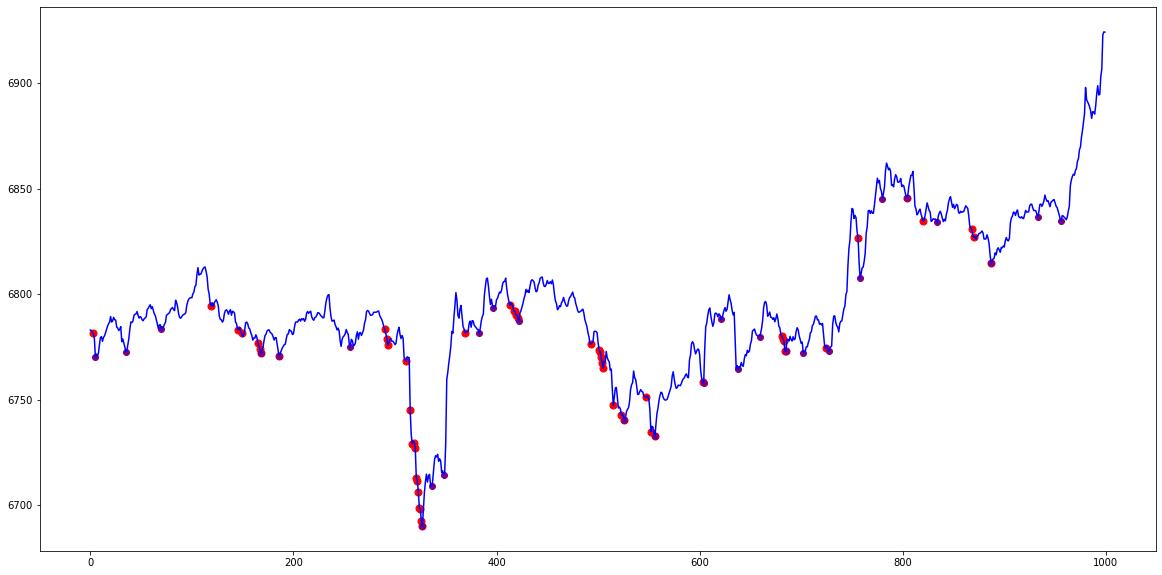

In [20]:
nu.graphPoints(smaller_view_data, mode="buy", plot_optimal=True)

In [23]:
nu.exportModel(clf, model_name, new_version=False, indicators=indicators, features=features, proba_threshold=0.0, is_nn=False)